#### 1. **Importing the required libraries:**




In [1]:
import tensorflow as tf  ### TensorFlow and its Keras module for building and training neural networks.
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt  ### Matplotlib for visualizing images and plots.
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

#### **2. Loading the dataset:**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Traffic Signs",  #### load images from a directory.
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #### takes parameters such as directory path, seed for shuffling, image size, and batch size.
    batch_size=BATCH_SIZE ###  ### The dataset is stored in the dataset variable.
)

Found 179 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names ## the different categories

['Give Way', 'No Entry', 'Right Curve', 'Speed Limit', 'Stop']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 4 0 0 0 4 3 2 1 4 2 3 2 3 1 4 4 1 4 0 1 3 4 0 0 0 2 2 2 3 1 4]


#### 3. **Displaying sample images:**

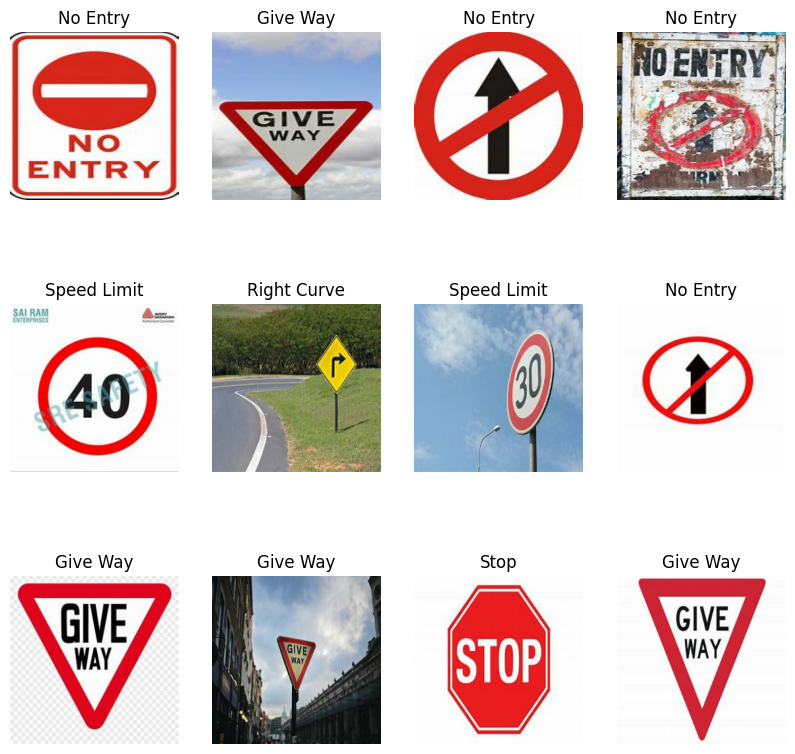

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

6

#### **4.Training Testing and Validation:**

In [8]:
train_size = 0.8
len(dataset)*train_size

4.800000000000001

In [9]:
train_ds = dataset.take(54)
len(train_ds)

6

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

0.6000000000000001

In [12]:
val_ds = test_ds.take(5)
len(val_ds)

0

In [13]:
test_ds = test_ds.skip(5)
len(test_ds)

0

#### 5. **Partitioning the dataset:**

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ### training, testing and validation dataset
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

4

In [17]:
len(val_ds)

0

In [18]:
len(test_ds)

2

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### 6. **Data augmentation:**

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


#### 7. **Model architecture:**

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

#### 8. **Model compilation:**

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


#### 9. **Model training:**

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
4/4 [==============================] - 22s 5s/step - loss: 1.7466 - accuracy: 0.1826
Epoch 2/20
4/4 [==============================] - 20s 4s/step - loss: 1.6245 - accuracy: 0.2087
Epoch 3/20
4/4 [==============================] - 18s 4s/step - loss: 1.5916 - accuracy: 0.3217
Epoch 4/20
4/4 [==============================] - 17s 4s/step - loss: 1.4262 - accuracy: 0.3565
Epoch 5/20
4/4 [==============================] - 18s 5s/step - loss: 1.1936 - accuracy: 0.4957
Epoch 6/20
4/4 [==============================] - 17s 5s/step - loss: 1.0562 - accuracy: 0.5565
Epoch 7/20
4/4 [==============================] - 20s 5s/step - loss: 0.9765 - accuracy: 0.6000
Epoch 8/20
4/4 [==============================] - 17s 5s/step - loss: 0.8963 - accuracy: 0.5913
Epoch 9/20
4/4 [==============================] - 19s 4s/step - loss: 0.7985 - accuracy: 0.6522
Epoch 10/20
4/4 [==============================] - 17s 4s/step - loss: 0.7441 - accuracy: 0.7043
Epoch 11/20
4/4 [======================

#### 10. **Model Evaluation:**

In [27]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 3s 1s/step - loss: 0.5165 - accuracy: 0.8281


In [28]:
scores

[0.5165196657180786, 0.828125]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 4}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

20

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7466055154800415,
 1.6245431900024414,
 1.591627597808838,
 1.4261736869812012,
 1.193569540977478]

first image to predict
actual label: Speed Limit
1/1 [==============================] - 1s 1s/step
predicted label: Right Curve


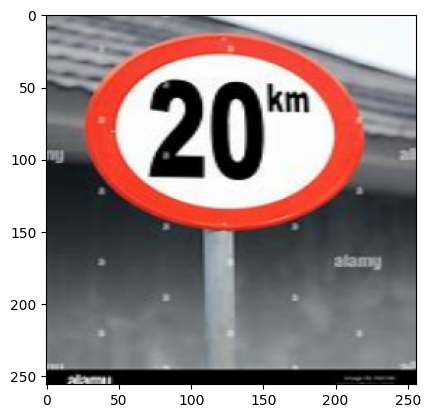

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8') #extracts the first image from the batch and converts it to a NumPy array.
    first_label = labels_batch[0].numpy() #retrieves the corresponding label for the first image in the batch.

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converts the input image (in NumPy array format) to a TensorFlow tensor
    img_array = tf.expand_dims(img_array, 0) #reshapes the tensor to have a batch dimension of 1, as the model expects input in batch format.

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### 11. **Visualising Predictions:**

1/1 [==============================] - 0s 88ms/step


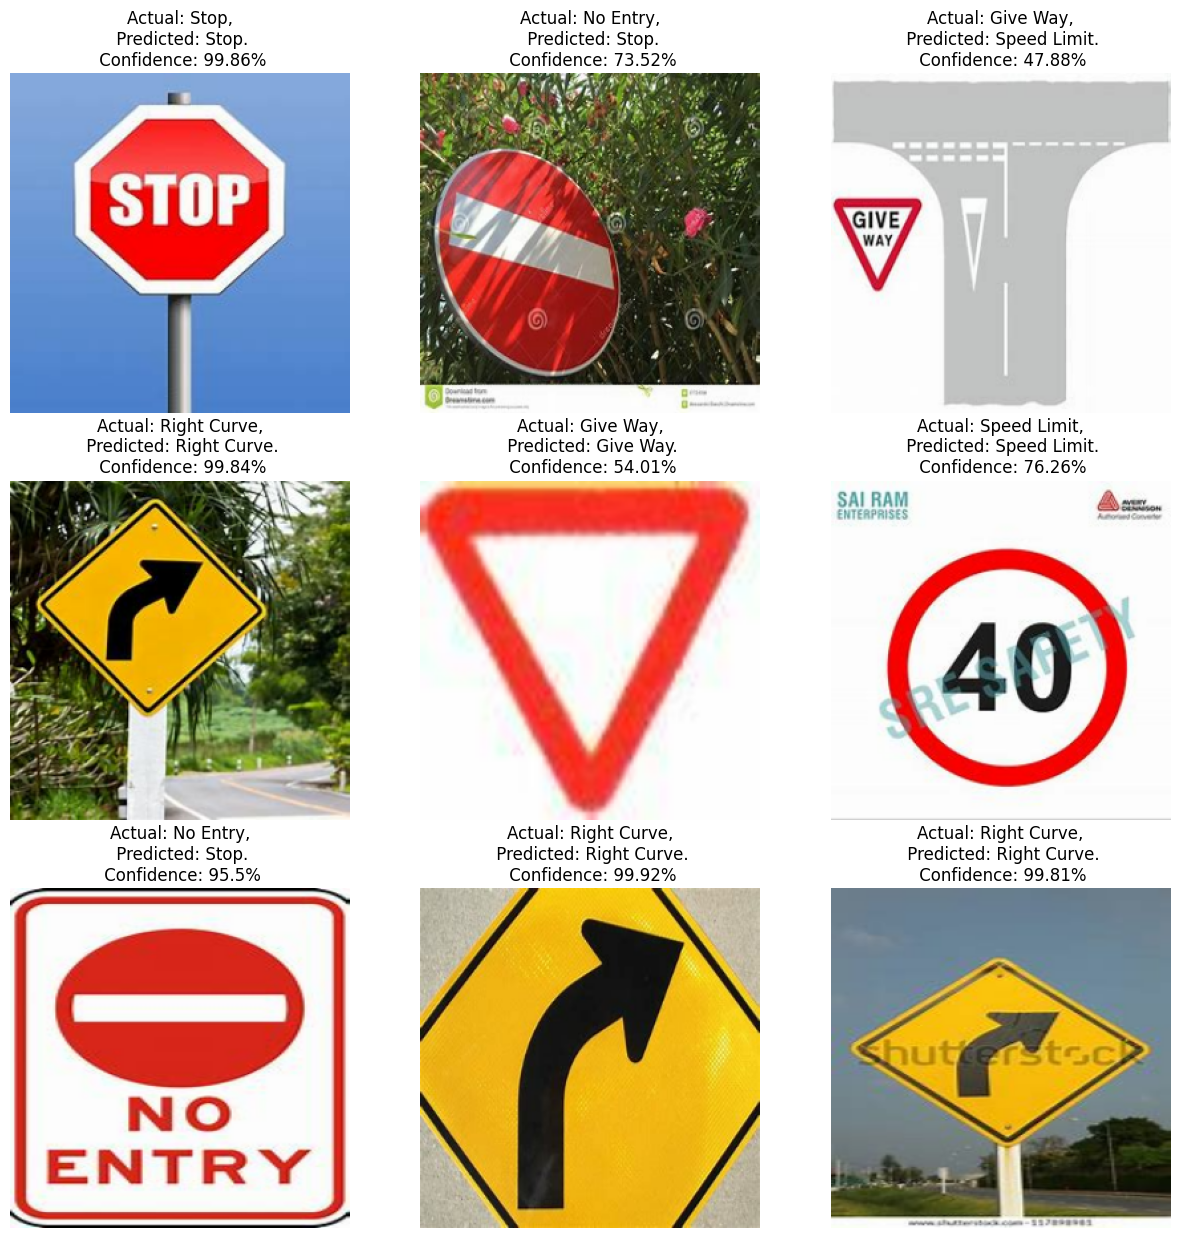

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] ### the actual class

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        ## predicted class
        plt.axis("off")

In [38]:
model.save('./models', save_format='tf')

#### **12. Install Gradio**

In [39]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [40]:
import gradio as gr

In [41]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(5)}

In [42]:
image = gr.inputs.Image(shape=(256,256)) ### 256x256 pixel
label = gr.outputs.Label(num_top_classes=5) ## 5 predicted classes


<ipython-input-42-6a217735a4c2>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(256,256)) ### 256x256 pixel
<ipython-input-42-6a217735a4c2>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(256,256)) ### 256x256 pixel
<ipython-input-42-6a217735a4c2>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=5) ## 5 predicted classes
<ipython-input-42-6a217735a4c2>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=5) ## 5 predicted classes


In [43]:
gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 70ms/step
Keyboard interruption in main thread... closing server.
